In [5]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import os, csv
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [6]:
# Determine important landmarks for biceps
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "RIGHT_ELBOW",
    "LEFT_ELBOW",
    "RIGHT_WRIST",
    "LEFT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
]

# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [7]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Ignore if file is already exist
    if os.path.exists(dataset_path):
        return

    # Write all the columns to a empty file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(HEADERS)


def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def remove_duplicate_rows(dataset_path: str):
    '''
    Remove duplicated data from the dataset then save it to another files
    '''
    
    df = pd.read_csv(dataset_path)
    df.drop_duplicates(keep="first", inplace=True)
    df.to_csv(f"cleaned_train.csv", sep=',', encoding='utf-8', index=False)
    

def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)

In [4]:
DATASET_PATH = "train.csv"
VIDEOS_FOLDER = "C:/Users/Alrowad/Exercise-correction/bicpes_model/dataset/train"

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for filename in os.listdir(VIDEOS_FOLDER):
        if not filename.endswith(".mp4"):
            continue
        
        cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, filename))
        save_counts = 0
        
        while cap.isOpened():
            ret, image = cap.read()
    
            if not ret:
                break
    
            # Reduce size of a frame
            image = rescale_frame(image, 60)
            image = cv2.flip(image, 1)
    
            # Recolor image from BGR to RGB for mediapipe
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
    
            results = pose.process(image)
    
            if not results.pose_landmarks:
                print("Cannot detect pose - No human found")
                continue
    
            # Recolor image from BGR to RGB for mediapipe
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
            # Draw landmarks and connections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
    
            # Display the saved count
            cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
    
            cv2.imshow("CV2", image)
    
            # Pressed key for action
            k = cv2.waitKey(1) & 0xFF
    
            # Press C to save as correct form
            if k == ord('c'): 
                export_landmark_to_csv(DATASET_PATH, results, "C")
                save_counts += 1
            # Press L to save as low back
            elif k == ord("l"):
                export_landmark_to_csv(DATASET_PATH, results, "L")
                save_counts += 1
    
            # Press q to stop
            elif k == ord("q"):
                break
            else:
                continue
    
        cap.release()
        cv2.destroyAllWindows()
    
        # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
        for i in range (1, 5):
            cv2.waitKey(1)

Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No huma

Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No huma

Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No human found
Cannot detect pose - No huma

In [5]:
# csv_files = [os.path.join("./", f) for f in os.listdir("./") if "csv" in f]

# concat_csv_files_with_same_headers(csv_files, "train.csv")

df = describe_dataset("./train.csv")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 979 
Number of columns: 37

Labels: 
C    557
L    422
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [6]:
remove_duplicate_rows("./train.csv")


Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 979 
Number of columns: 37

Labels: 
C    557
L    422
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


<AxesSubplot:xlabel='label', ylabel='count'>

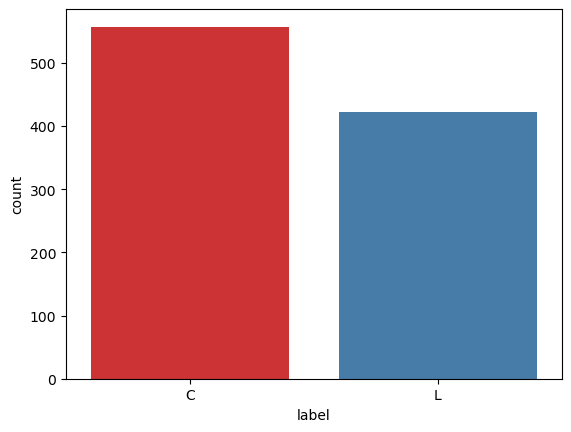

In [7]:
df = describe_dataset("./train.csv")
sns.countplot(x='label', data=df, palette="Set1")

In [1]:
DATASET_PATH = "test.csv"
# VIDEOS_FOLDER = "C:/Users/Alrowad/Exercise-correction/bicpes_model/dataset/test"

# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     for filename in os.listdir(VIDEOS_FOLDER):
#         if not filename.endswith(".mp4"):
#             continue
        
#         cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, filename))
#         save_counts = 0
        
#         while cap.isOpened():
#             ret, image = cap.read()
    
#             if not ret:
#                 break
    
#             # Reduce size of a frame
#             image = rescale_frame(image, 60)
#             image = cv2.flip(image, 1)
    
#             # Recolor image from BGR to RGB for mediapipe
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image.flags.writeable = False
    
#             results = pose.process(image)
    
#             if not results.pose_landmarks:
#                 print("Cannot detect pose - No human found")
#                 continue
    
#             # Recolor image from BGR to RGB for mediapipe
#             image.flags.writeable = True
#             image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
#             # Draw landmarks and connections
#             mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
    
#             # Display the saved count
#             cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
    
#             cv2.imshow("CV2", image)
    
#             # Pressed key for action
#             k = cv2.waitKey(1) & 0xFF
    
#             # Press C to save as correct form
#             if k == ord('c'): 
#                 export_landmark_to_csv(DATASET_PATH, results, "C")
#                 save_counts += 1
#             # Press L to save as low back
#             elif k == ord("l"):
#                 export_landmark_to_csv(DATASET_PATH, results, "L")
#                 save_counts += 1
    
#             # Press q to stop
#             elif k == ord("q"):
#                 break
#             else:
#                 continue
    
#         cap.release()
#         cv2.destroyAllWindows()
    
#         # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
#         for i in range (1, 5):
#             cv2.waitKey(1)

In [8]:
test_df = describe_dataset(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 419 
Number of columns: 37

Labels: 
L    269
C    150
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


<AxesSubplot:xlabel='count', ylabel='label'>

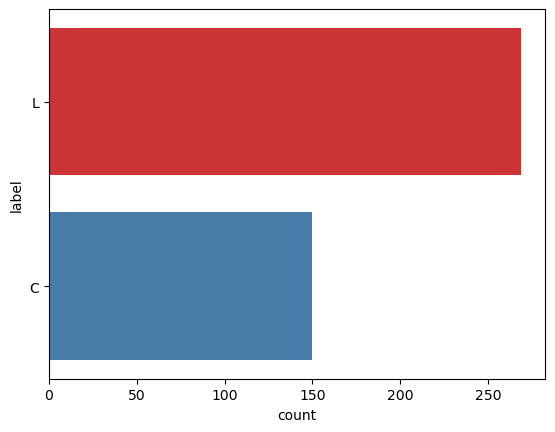

In [9]:
sns.countplot(y='label', data=test_df, palette="Set1")